In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow_addons as tfa

f:\MultiCoreWare\Environments\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
f:\MultiCoreWare\Environments\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want

In [2]:
(x_data, y_data), (x_test, y_test) = mnist.load_data()

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [4]:
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [7]:
def augment(image, label):
    image = tfa.image.rotate(image, tf.random.uniform([], -0.2, 0.2))
    scales = tf.random.uniform([], 0.8, 1.0)
    crop_size = tf.cast(scales * tf.cast(tf.shape(image)[:2], tf.float32), tf.int32)
    image = tf.image.random_crop(image, size=[crop_size[0], crop_size[1], 3])
    image = tf.image.resize(image, (224, 224))
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

In [5]:
def preprocess(image, label):
    # Add channel dimension and resize image
    image = tf.expand_dims(image, axis=-1)
    image = tf.image.resize(image, (224, 224))
    image = tf.image.grayscale_to_rgb(image)
    return image, tf.one_hot(label, 10)

In [8]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess).map(augment).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

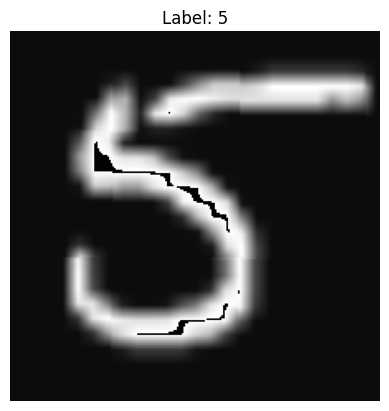

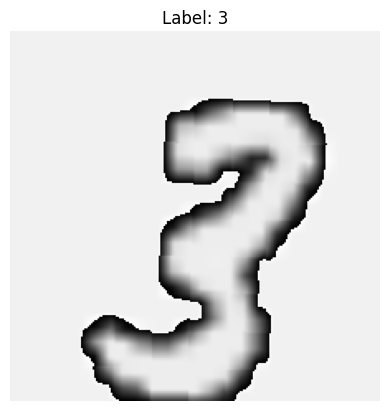

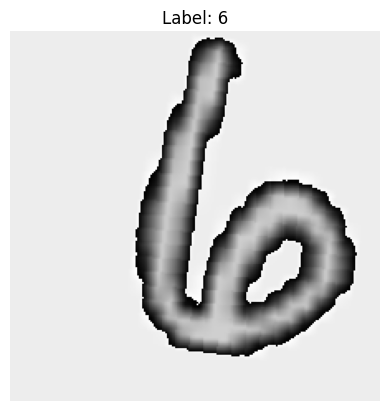

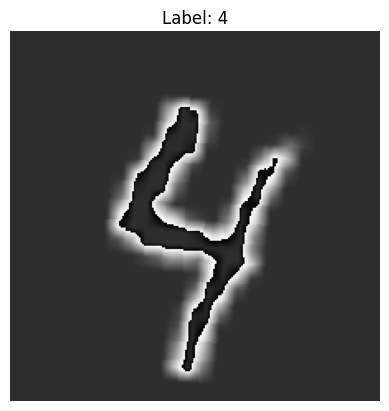

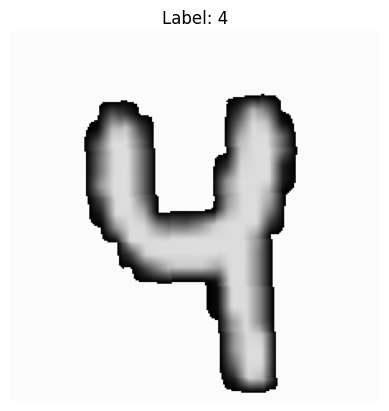

In [61]:
for images, labels in train_ds.take(5):
    # Convert the tensor to numpy for visualization
    image = images[0].numpy()  # Take the first image in the batch
    label = labels[0].numpy()  # Take the corresponding label

    # Since the image is in [0, 1] range, scale it back to [0, 255] for visualization (optional)
    image = (image * 255).astype('uint8')

    # Display the image
    plt.imshow(image)
    plt.title(f"Label: {tf.argmax(label).numpy()}")
    plt.axis('off')
    plt.show()

In [63]:
model = tf.keras.models.load_model("mnist_resnet_base.h5")

In [64]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

In [65]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/10
1500/1500 [==============================] - 267s 177ms/step - loss: 0.0937 - accuracy: 0.9722 - val_loss: 0.0511 - val_accuracy: 0.9843
Epoch 2/10
1500/1500 [==============================] - 267s 178ms/step - loss: 0.0645 - accuracy: 0.9802 - val_loss: 0.0487 - val_accuracy: 0.9865
Epoch 3/10
1500/1500 [==============================] - 268s 179ms/step - loss: 0.0586 - accuracy: 0.9824 - val_loss: 0.0451 - val_accuracy: 0.9868
Epoch 4/10
1500/1500 [==============================] - 274s 182ms/step - loss: 0.0588 - accuracy: 0.9819 - val_loss: 0.0524 - val_accuracy: 0.9846
Epoch 5/10
1500/1500 [==============================] - 273s 182ms/step - loss: 0.0521 - accuracy: 0.9847 - val_loss: 0.0535 - val_accuracy: 0.9840
Epoch 6/10
1500/1500 [==============================] - 276s 184ms/step - loss: 0.0523 - accuracy: 0.9847 - val_loss: 0.0560 - val_accuracy: 0.9837


In [66]:
model.save('mnist_data_aug_resnet.h5')

In [67]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")

Training Accuracy: 0.984666645526886
Validation Accuracy: 0.9836666584014893


In [68]:
y_pred = model.predict(test_ds)
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()
y_true = y_test.flatten()

313/313 [==============================] - 18s 58ms/step


In [69]:
report = classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(10)])
print("\nClassification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.96      0.98      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.97      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.97      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



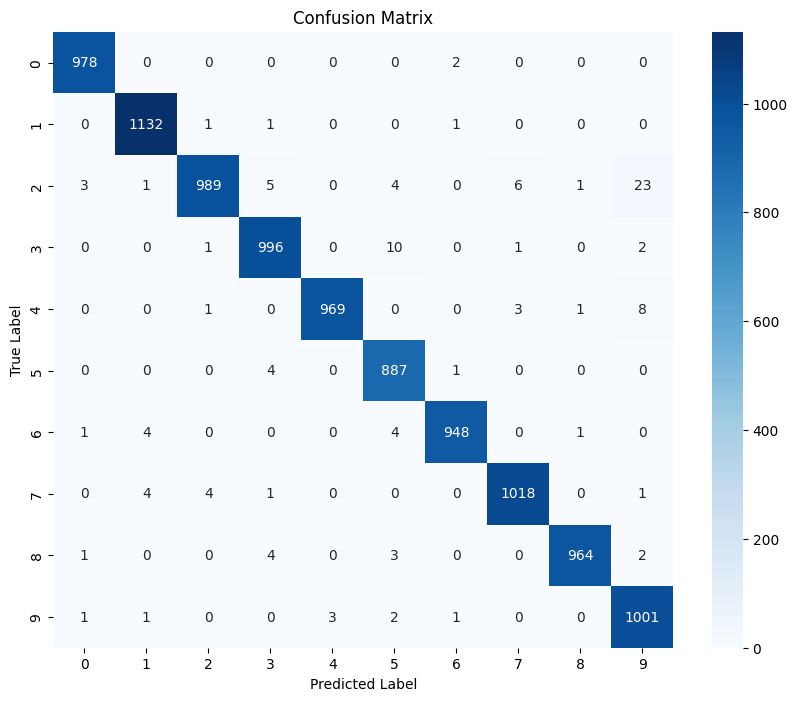

In [70]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()